# Macroeconometrics Project

Replication and extension study for the discussion paper 'An empirical assessment of the U.S. Phillips curve over time' by Marente Vlekke, Siem Jan Koopman and Martin Mellens.

In [170]:
import arviz as az
import jax
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import plotnine as p9
import statsmodels.api as sm

from pandas_datareader import fred
from scipy import stats, optimize
from statsmodels.base.model import GenericLikelihoodModel

In [171]:
jax.config.update('jax_platform_name', 'cpu')
numpyro.set_host_device_count(8)

In [172]:
seed = sum(map(ord, 'Macroeconometrics project, Vlekke, Kooman and Mellens replication'))
rng = np.random.default_rng(seed)

## Data

In [173]:
import datetime
import requests_cache

session = requests_cache.CachedSession(cache_name='fred', backend='sqlite', expire_after=datetime.timedelta(days=1))

fred_symbols = [
    # Inflation
    'CPIAUCSL', # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average, Index 1982-1984=100, Seasonally Adjusted, Monthly
    'CPILFESL', #  Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average, Index 1982-1984=100, Seasonally Adjusted, Monthly
    'PCEPI', # Personal Consumption Expenditures: Chain-type Price Index, Index 2017=100, Seasonally Adjusted, Monthly
    'PCEPILFE', # Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), Index 2017=100, Seasonally Adjusted, Monthly
    # Unemployment
    'UNRATE', # Unemployment Rate, Percent, Seasonally Adjusted, Monthly
    'NROU', # Noncyclical Rate of Unemployment, Percent, Not Seasonally Adjusted, Quarterly
    # GDP
    'GDP', # Gross Domestic Product, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
    'NGDPPOT', # Nominal Potential Gross Domestic Product, Billions of Dollars, Not Seasonally Adjusted, Quarterly
    'GDPPOT', # Real Potential Gross Domestic Product, Billions of Chained 2017 Dollars, Not Seasonally Adjusted, Quarterly
    # Supply shock control variables
    'A021RD3Q086SBEA', # Imports of goods and services (implicit price deflator), Index 2017=100, Seasonally Adjusted, Quarterly
    'GDPDEF', # Gross Domestic Product: Implicit Price Deflator, Index 2017=100, Seasonally Adjusted, Quarterly
    'WTISPLC', # Spot Crude Oil Price: West Texas Intermediate (WTI), Dollars per Barrel, Not Seasonally Adjusted, Monthly
    # Interest rate
    'FEDFUNDS', # Federal Funds Effective Rate, Percent, Not Seasonally Adjusted, Monthly
    # Inflation expectations
    'MICH', # University of Michigan: Inflation Expectation, Percent, Not Seasonally Adjusted, Monthly
]

fred_raw = fred.FredReader(symbols=fred_symbols, start=1900, end=2025, session=session).read()

In [174]:
# Resample data as quarterly data, take the last observation during that period
fred_df = fred_raw.resample('QS').last()

# Limit data to before 2025
fred_df = fred_df[fred_df.index < '2025-01-01']

# Calculate annualized quarter-on-quarter inflation changes
fred_df['cpi'] = ((1 + fred_df['CPIAUCSL'].pct_change()) ** 4 - 1) * 100
fred_df['cpix'] = ((1 + fred_df['CPILFESL'].pct_change()) ** 4 - 1) * 100
fred_df['pce'] = ((1 + fred_df['PCEPI'].pct_change()) ** 4 - 1) * 100
fred_df['pcex'] = ((1 + fred_df['PCEPILFE'].pct_change()) ** 4 - 1) * 100

# Unemployment
fred_df['u'] = fred_df['UNRATE']
fred_df['u_n'] = fred_df['NROU']
fred_df['u_gap'] = fred_df['u'] - fred_df['u_n']

# Supply shock control variables
fred_df['imp'] = fred_df['A021RD3Q086SBEA']
fred_df['gdp_def'] = fred_df['GDPDEF']
fred_df['rel_imp_p_idx'] = fred_df['imp'] / fred_df['gdp_def']
fred_df['rel_imp_p'] = ((1 + fred_df['rel_imp_p_idx'].pct_change(fill_method=None)) ** 4 - 1) * 100
fred_df['oil_p'] = ((1 + fred_df['WTISPLC'].pct_change()) ** 4 - 1) * 100

# Interest rates
fred_df['i'] = fred_df['FEDFUNDS']

# Cosnumer inflation expectations
fred_df['e_h_cpi_1'] = fred_df['MICH']

# Backwards-looking expectations
fred_df['e_b_cpi'] = fred_df['cpi'].rolling(window=4).mean().shift(1)
fred_df['e_b_cpix'] = fred_df['cpix'].rolling(window=4).mean().shift(1)
fred_df['e_b_pce'] = fred_df['pce'].rolling(window=4).mean().shift(1)
fred_df['e_b_pcex'] = fred_df['pcex'].rolling(window=4).mean().shift(1)

fred_df = fred_df[['cpi', 'cpix', 'pce', 'pcex', 'u', 'u_n', 'u_gap', 'imp', 'gdp_def', 'rel_imp_p_idx', 'rel_imp_p', 'oil_p', 'i', 'e_h_cpi_1', 'e_b_cpi', 'e_b_cpix', 'e_b_pce', 'e_b_pcex']]

In [175]:
fred_df.tail()

,cpi,cpix,pce,pcex,u,u_n,u_gap,imp,gdp_def,rel_imp_p_idx,rel_imp_p,oil_p,i,e_h_cpi_1,e_b_cpi,e_b_cpix,e_b_pce,e_b_pcex
DATE,,,,,,,,,,,,,,,,,,
2023-10-01,1.906163,3.343949,0.710362,1.636068,3.8,4.419751,-0.619751,111.058,123.241,0.901145,-1.537027,-58.218634,5.33,3.1,3.695399,4.145765,3.416978,3.660718
2024-01-01,4.596141,4.530819,4.379274,4.388082,3.9,4.416962,-0.516962,111.786,124.163,0.900317,-0.367200,63.312421,5.33,2.9,3.327616,3.912671,2.708934,3.042222
2024-04-01,1.053362,2.097782,1.495558,2.254738,4.1,4.414191,-0.314191,112.372,124.943,0.899386,-0.412725,-7.226575,5.33,3.0,3.480896,3.798862,2.818251,2.985381
2024-07-01,2.108149,3.076850,1.860962,2.384926,4.1,4.411415,-0.311415,112.314,125.532,0.894704,-2.066097,-39.885444,5.13,2.7,2.987139,3.280547,2.446188,2.635745
2024-10-01,2.249526,2.377763,1.437419,1.517888,4.1,4.408619,-0.308619,NaN,NaN,NaN,NaN,-0.681622,4.48,2.6,2.415954,3.262350,2.111539,2.665953


In [176]:
spf_files = [
    'Median_CPI_Level.xlsx',
    'Median_CPI5YR_Level.xlsx',
    'Median_CPI10_Level.xlsx',
    'Median_CORECPI_Level.xlsx',
    'Median_COREPCE_Level.xlsx',
    'Median_PCE_Level.xlsx',
    'Median_PCE5YR_Level.xlsx',
    'Median_PCE10_Level.xlsx',
]

spf_raw = pd.concat([pd.read_excel(f'data/{spf_file}').set_index(['YEAR', 'QUARTER']) for spf_file in spf_files], axis=1)
spf_raw.columns

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it wi

Index(['CPI1', 'CPI2', 'CPI3', 'CPI4', 'CPI5', 'CPI6', 'CPIA', 'CPIB', 'CPIC',
       'CPI5YR', 'CPI10', 'CORECPI1', 'CORECPI2', 'CORECPI3', 'CORECPI4',
       'CORECPI5', 'CORECPI6', 'CORECPIA', 'CORECPIB', 'CORECPIC', 'COREPCE1',
       'COREPCE2', 'COREPCE3', 'COREPCE4', 'COREPCE5', 'COREPCE6', 'COREPCEA',
       'COREPCEB', 'COREPCEC', 'PCE1', 'PCE2', 'PCE3', 'PCE4', 'PCE5', 'PCE6',
       'PCEA', 'PCEB', 'PCEC', 'PCE5YR', 'PCE10'],
      dtype='object')

In [177]:
spf_df = spf_raw[['CPIA', 'CPI10', 'CORECPIA', 'PCEA', 'PCE10', 'COREPCEA']]
spf_df = spf_df.rename(columns={
    'CPIA': 'e_p_cpi_1',
    'CPI10': 'e_p_cpi_10',
    'CORECPIA': 'e_p_cpix_1',
    'PCEA': 'e_p_pce_1',
    'PCE10': 'e_p_pce_10',
    'COREPCEA': 'e_p_pcex_1',
})
spf_df = spf_df.reset_index()
spf_df['DATE'] = spf_df['YEAR'].astype(str) + '-Q' + spf_df['QUARTER'].astype(str)
spf_df['DATE'] = pd.PeriodIndex(spf_df['DATE'], freq='Q').to_timestamp()
spf_df = spf_df.drop(columns=['YEAR', 'QUARTER']).set_index('DATE')

In [178]:
spf_df.tail()

,e_p_cpi_1,e_p_cpi_10,e_p_cpix_1,e_p_pce_1,e_p_pce_10,e_p_pcex_1
DATE,,,,,,
2023-10-01,3.3373,2.400,3.8922,3.1115,2.22,3.4625
2024-01-01,2.4905,2.240,2.6873,2.0948,2.00,2.1170
2024-04-01,3.1235,2.325,3.4000,2.7742,2.10,2.9094
2024-07-01,2.8471,2.300,3.1534,2.5511,2.10,2.8053
2024-10-01,2.5127,2.225,3.1000,2.3651,2.10,2.7375


In [179]:
df = fred_df.join(spf_df, how='outer')
df.index.freq = pd.tseries.frequencies.to_offset('QS')

# Inflation and expected inflation minus backwards-looking inflation expectations
df['cpi_meb'] = df['cpi'] - df['e_b_cpi']
df['cpix_meb'] = df['cpix'] - df['e_b_cpix']
df['pce_meb'] = df['pce'] - df['e_b_pce']
df['pcex_meb'] = df['pcex'] - df['e_b_pcex']

df['e_p_cpi_1_meb'] = df['e_p_cpi_1'] - df['e_b_cpi']
df['e_p_cpi_10_meb'] = df['e_p_cpi_10'] - df['e_b_cpi']
df['e_p_cpix_1_meb'] = df['e_p_cpix_1'] - df['e_b_cpix']
df['e_p_pce_1_meb'] = df['e_p_pce_1'] - df['e_b_pce']
df['e_p_pce_10_meb'] = df['e_p_pce_10'] - df['e_b_pce']
df['e_p_pcex_1_meb'] = df['e_p_pcex_1'] - df['e_b_pcex']

df['e_h_cpi_1_meb'] = df['e_h_cpi_1'] - df['e_b_cpi']

df.tail()

,cpi,cpix,pce,pcex,u,u_n,u_gap,imp,gdp_def,rel_imp_p_idx,...,cpix_meb,pce_meb,pcex_meb,e_p_cpi_1_meb,e_p_cpi_10_meb,e_p_cpix_1_meb,e_p_pce_1_meb,e_p_pce_10_meb,e_p_pcex_1_meb,e_h_cpi_1_meb
DATE,,,,,,,,,,,,,,,,,,,,,
2023-10-01,1.906163,3.343949,0.710362,1.636068,3.8,4.419751,-0.619751,111.058,123.241,0.901145,...,-0.801816,-2.706616,-2.024651,-0.358099,-1.295399,-0.253565,-0.305478,-1.196978,-0.198218,-0.595399
2024-01-01,4.596141,4.530819,4.379274,4.388082,3.9,4.416962,-0.516962,111.786,124.163,0.900317,...,0.618148,1.670339,1.345860,-0.837116,-1.087616,-1.225371,-0.614134,-0.708934,-0.925222,-0.427616
2024-04-01,1.053362,2.097782,1.495558,2.254738,4.1,4.414191,-0.314191,112.372,124.943,0.899386,...,-1.701081,-1.322693,-0.730643,-0.357396,-1.155896,-0.398862,-0.044051,-0.718251,-0.075981,-0.480896
2024-07-01,2.108149,3.076850,1.860962,2.384926,4.1,4.411415,-0.311415,112.314,125.532,0.894704,...,-0.203697,-0.585227,-0.250819,-0.140039,-0.687139,-0.127147,0.104912,-0.346188,0.169555,-0.287139
2024-10-01,2.249526,2.377763,1.437419,1.517888,4.1,4.408619,-0.308619,NaN,NaN,NaN,...,-0.884587,-0.674120,-1.148066,0.096746,-0.190954,-0.162350,0.253561,-0.011539,0.071547,0.184046


### Inflation

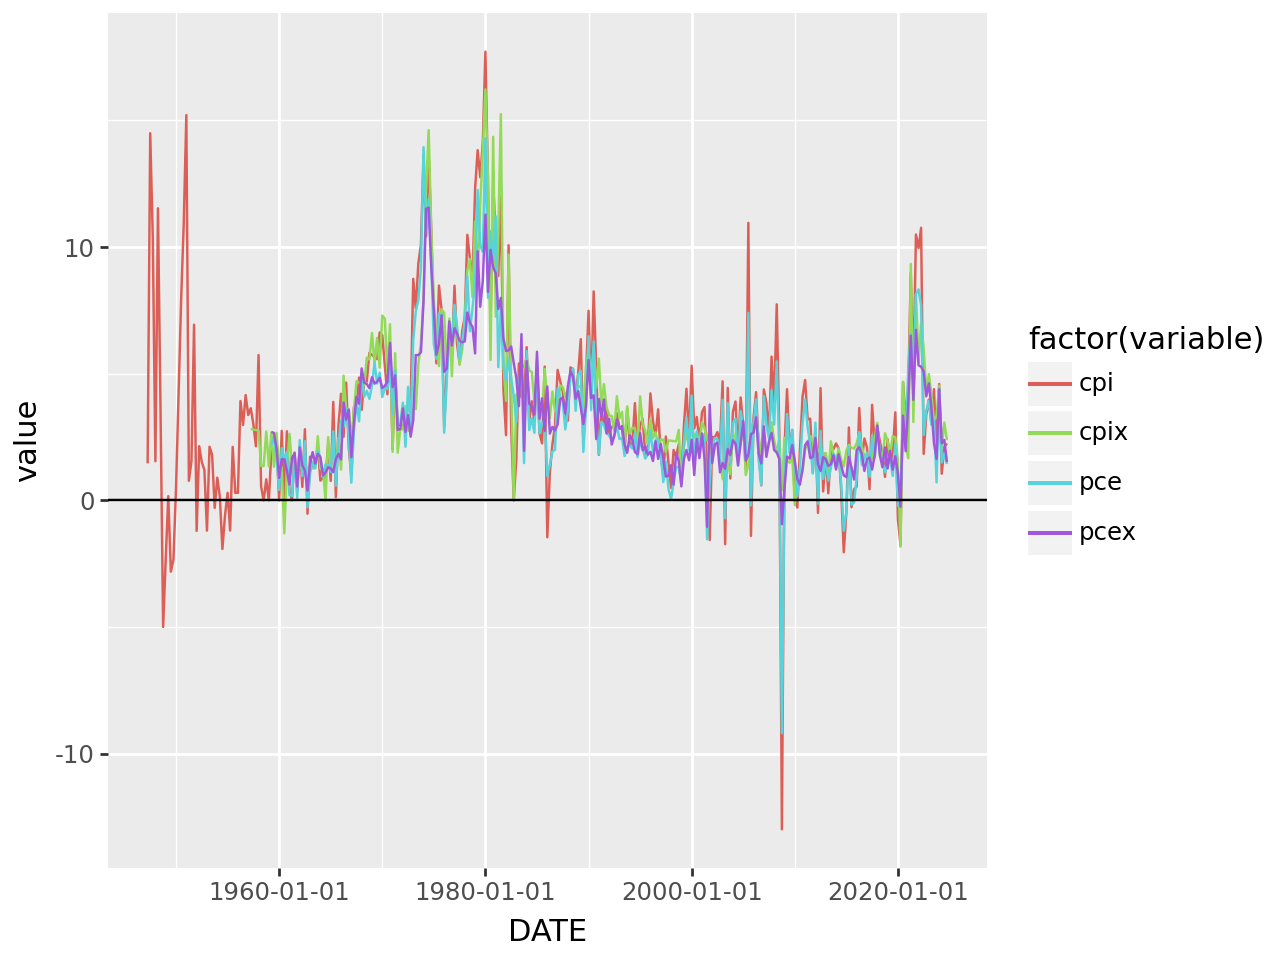

In [180]:
cpi_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['cpi', 'cpix', 'pce', 'pcex']).dropna()

(
    p9.ggplot(cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Inflation expectations

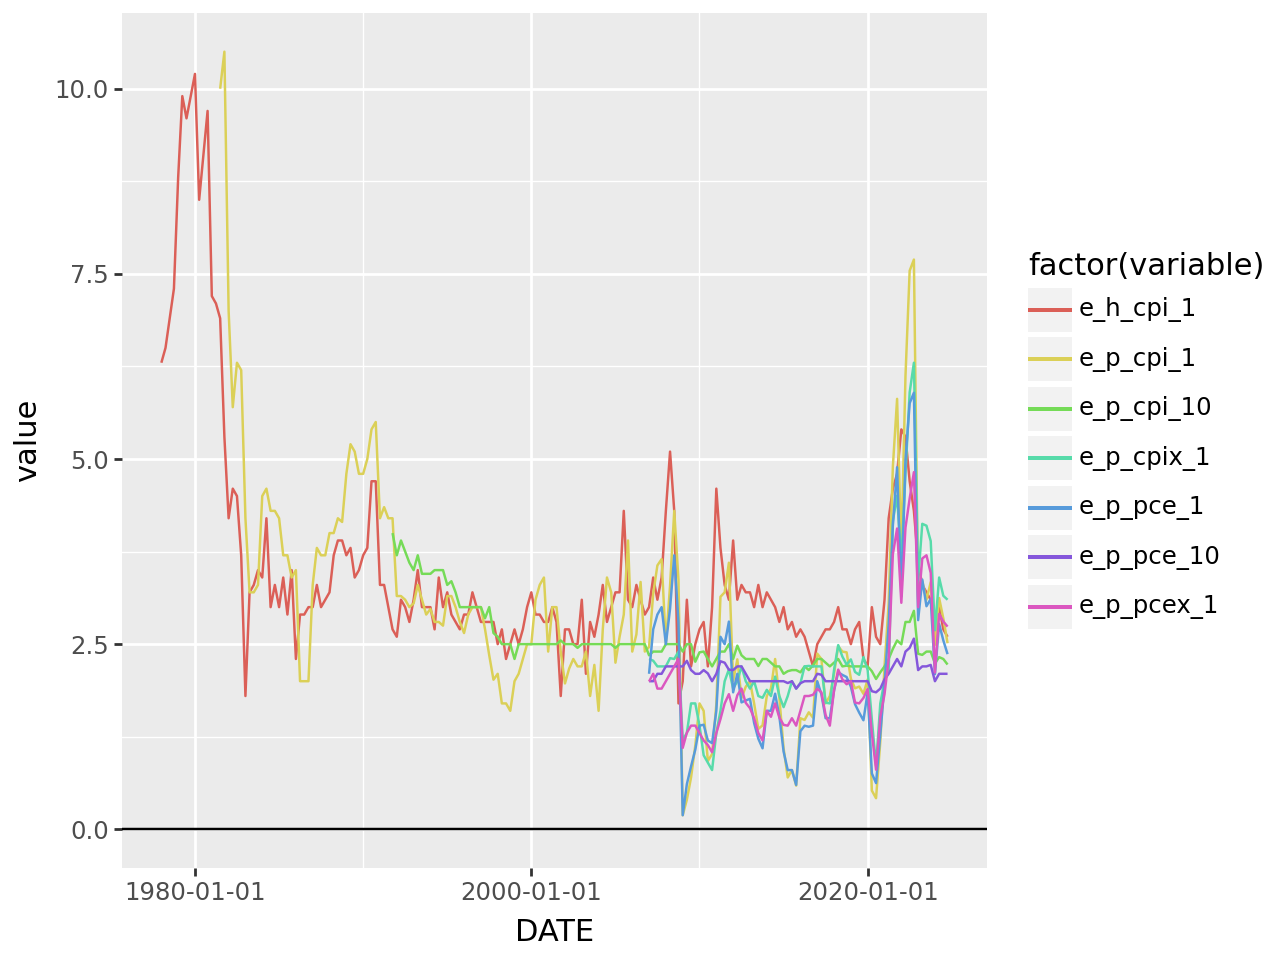

In [181]:
e_cpi_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['e_h_cpi_1', 'e_p_cpi_1', 'e_p_cpi_10', 'e_p_cpix_1', 'e_p_pce_1', 'e_p_pce_10', 'e_p_pcex_1']).dropna()

(
    p9.ggplot(e_cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Unemployment

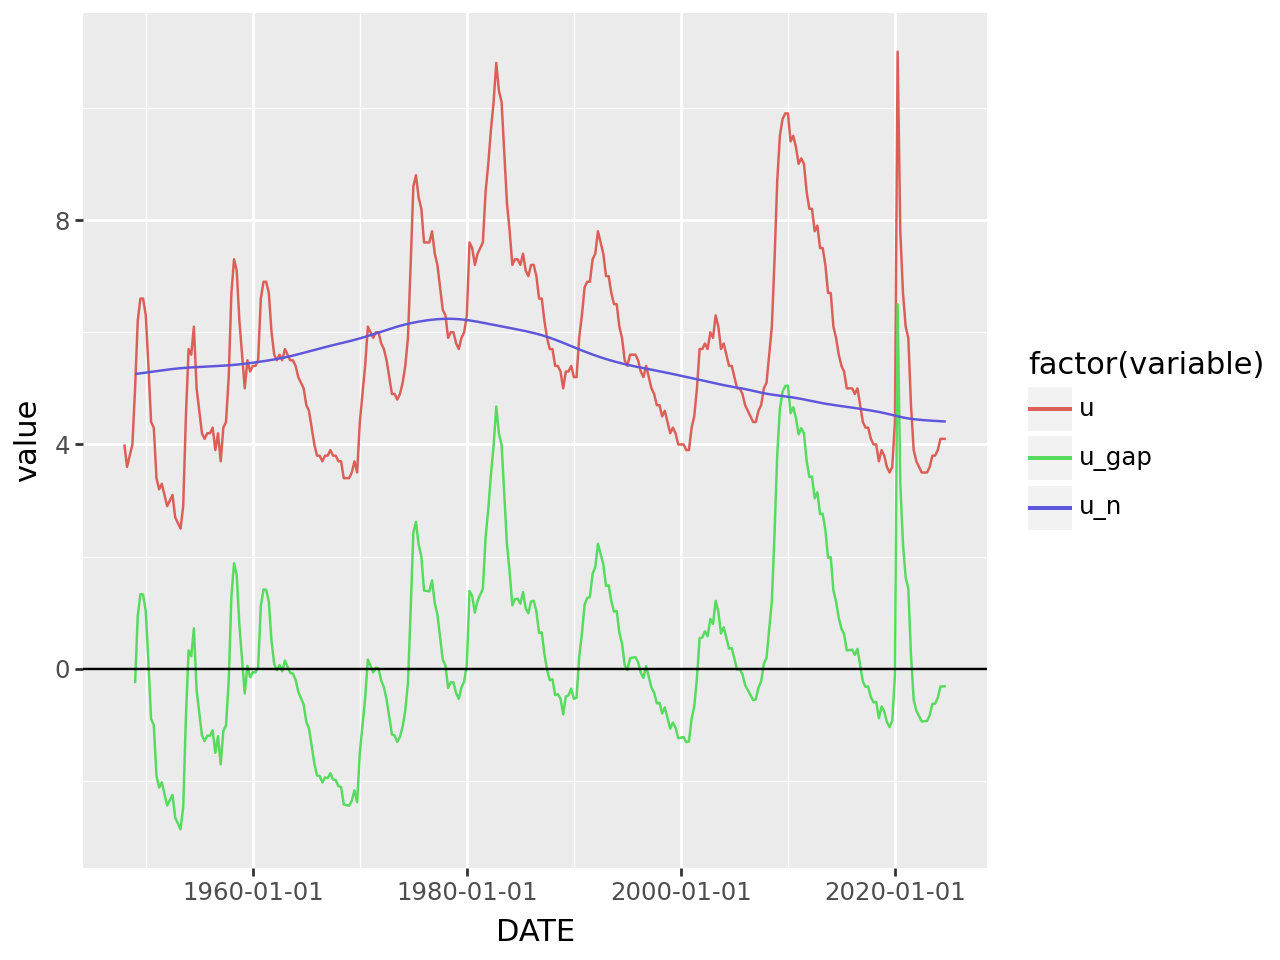

In [182]:
u_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['u', 'u_n', 'u_gap']).dropna()

(
    p9.ggplot(u_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Supply shocks

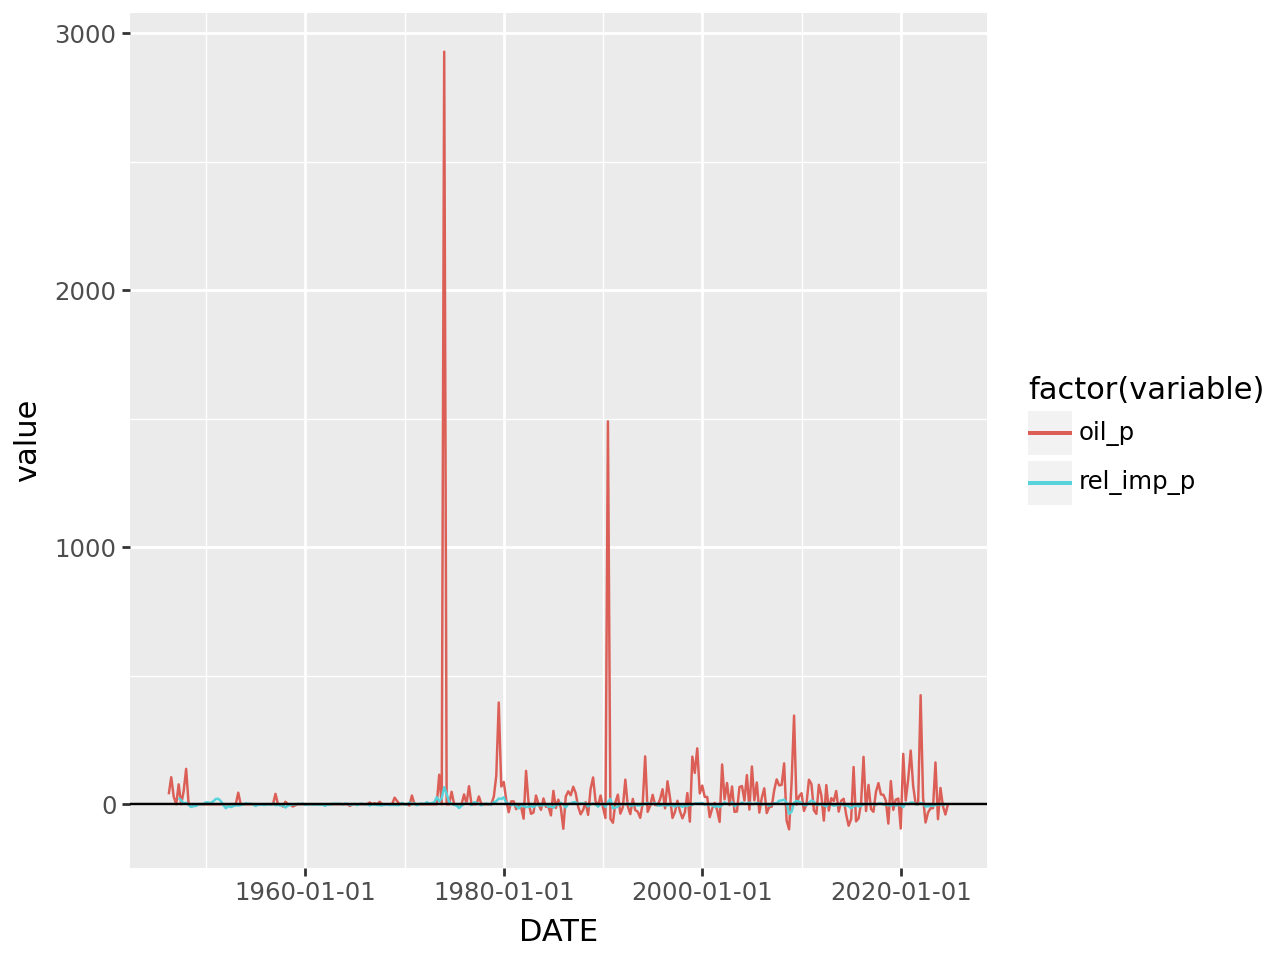

In [183]:
ip_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['rel_imp_p', 'oil_p']).dropna()

(
    p9.ggplot(ip_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Select Model Variables

In [199]:
model_df = df[['cpi', 'cpi_meb', 'u', 'u_n', 'u_gap', 'e_p_cpi_1', 'e_p_cpi_1_meb', 'e_h_cpi_1', 'e_h_cpi_1_meb', 'rel_imp_p', 'oil_p', 'e_b_cpi']].dropna()

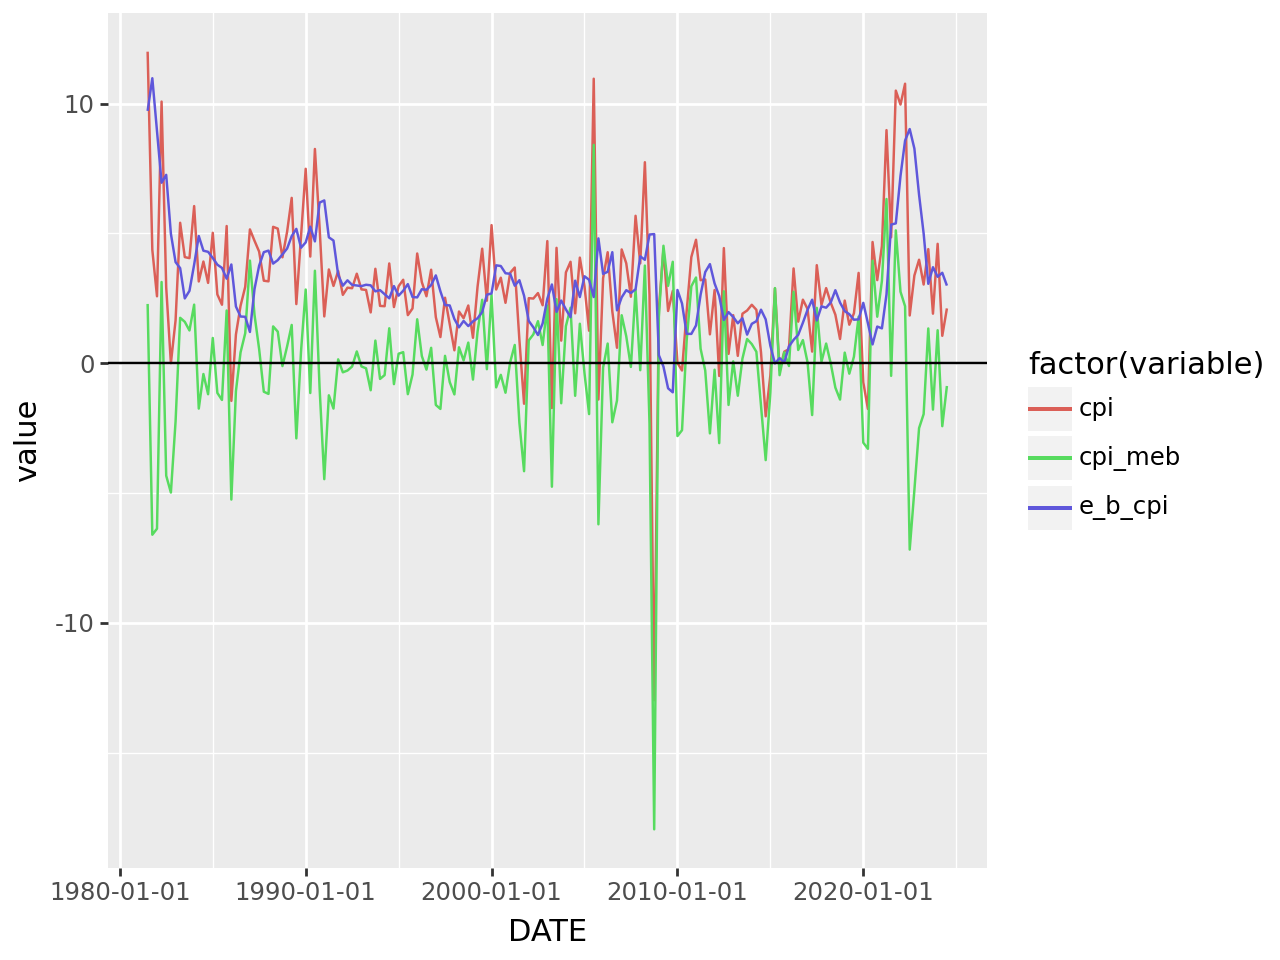

In [200]:
cpi_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['cpi', 'cpi_meb', 'e_b_cpi']).dropna()

(
    p9.ggplot(cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

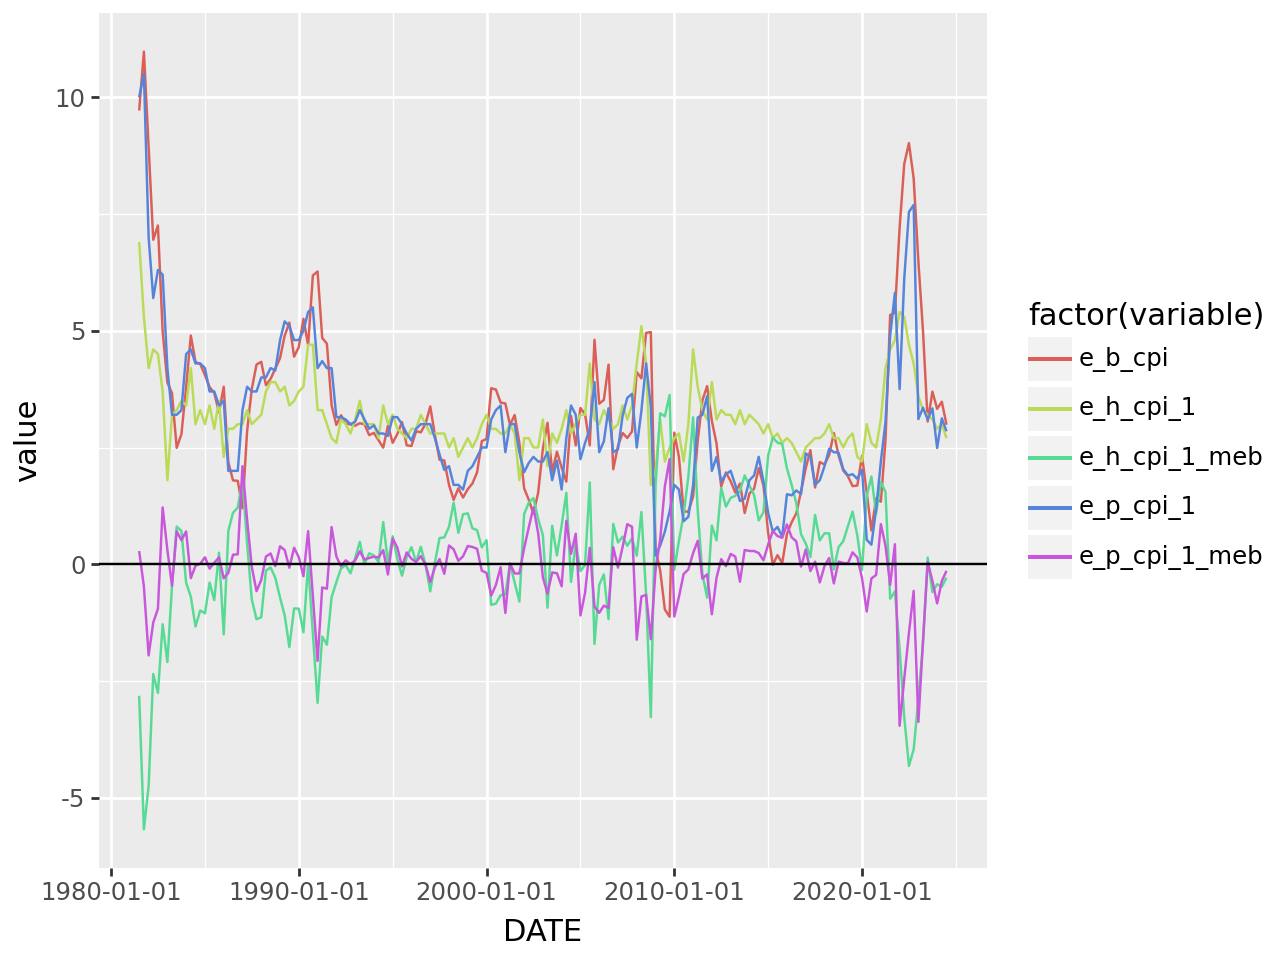

In [201]:
e_cpi_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['e_p_cpi_1', 'e_p_cpi_1_meb', 'e_h_cpi_1', 'e_h_cpi_1_meb', 'e_b_cpi']).dropna()

(
    p9.ggplot(e_cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

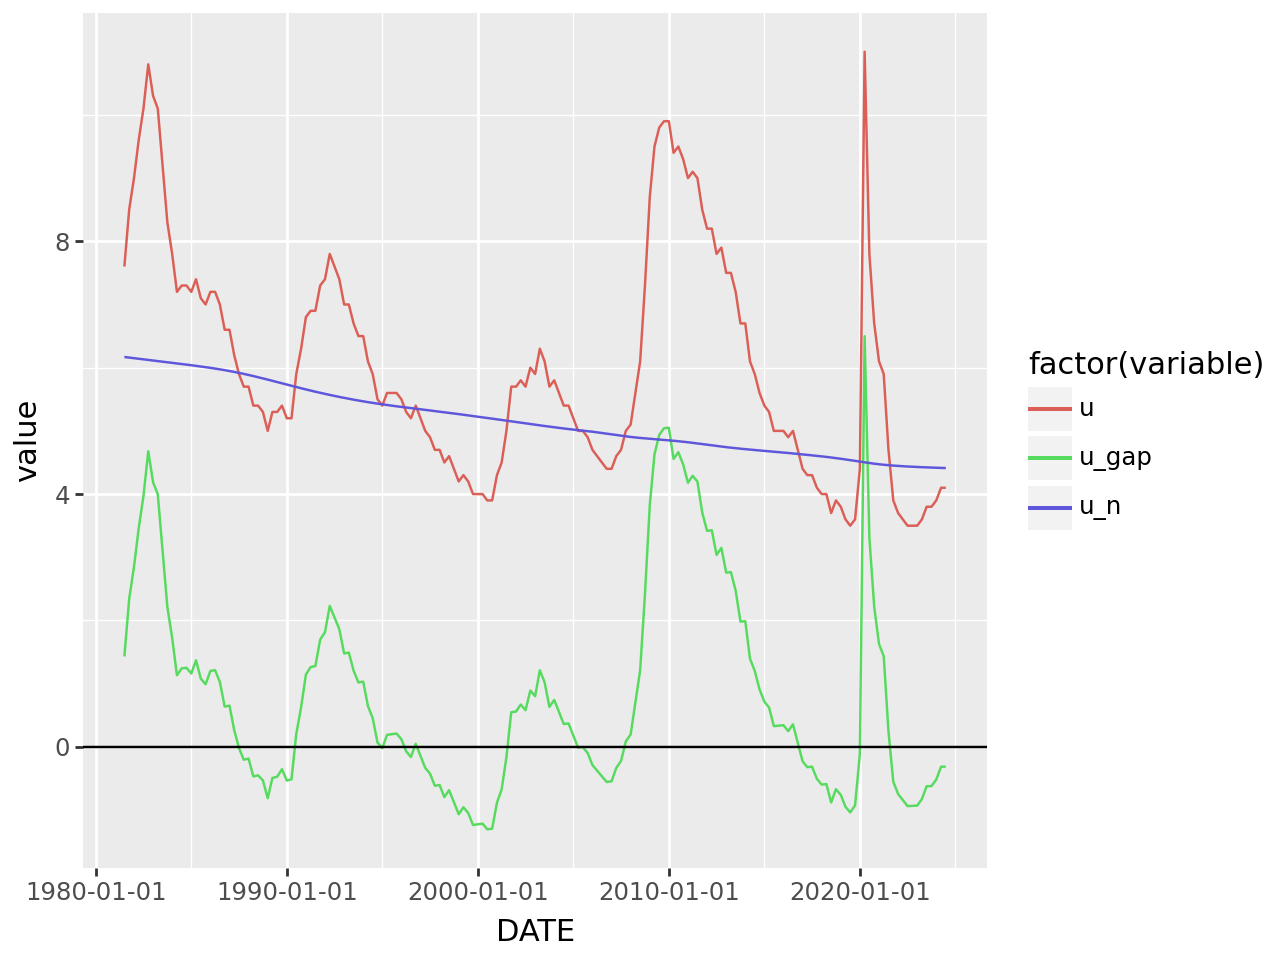

In [202]:
u_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['u', 'u_n', 'u_gap']).dropna()

(
    p9.ggplot(u_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

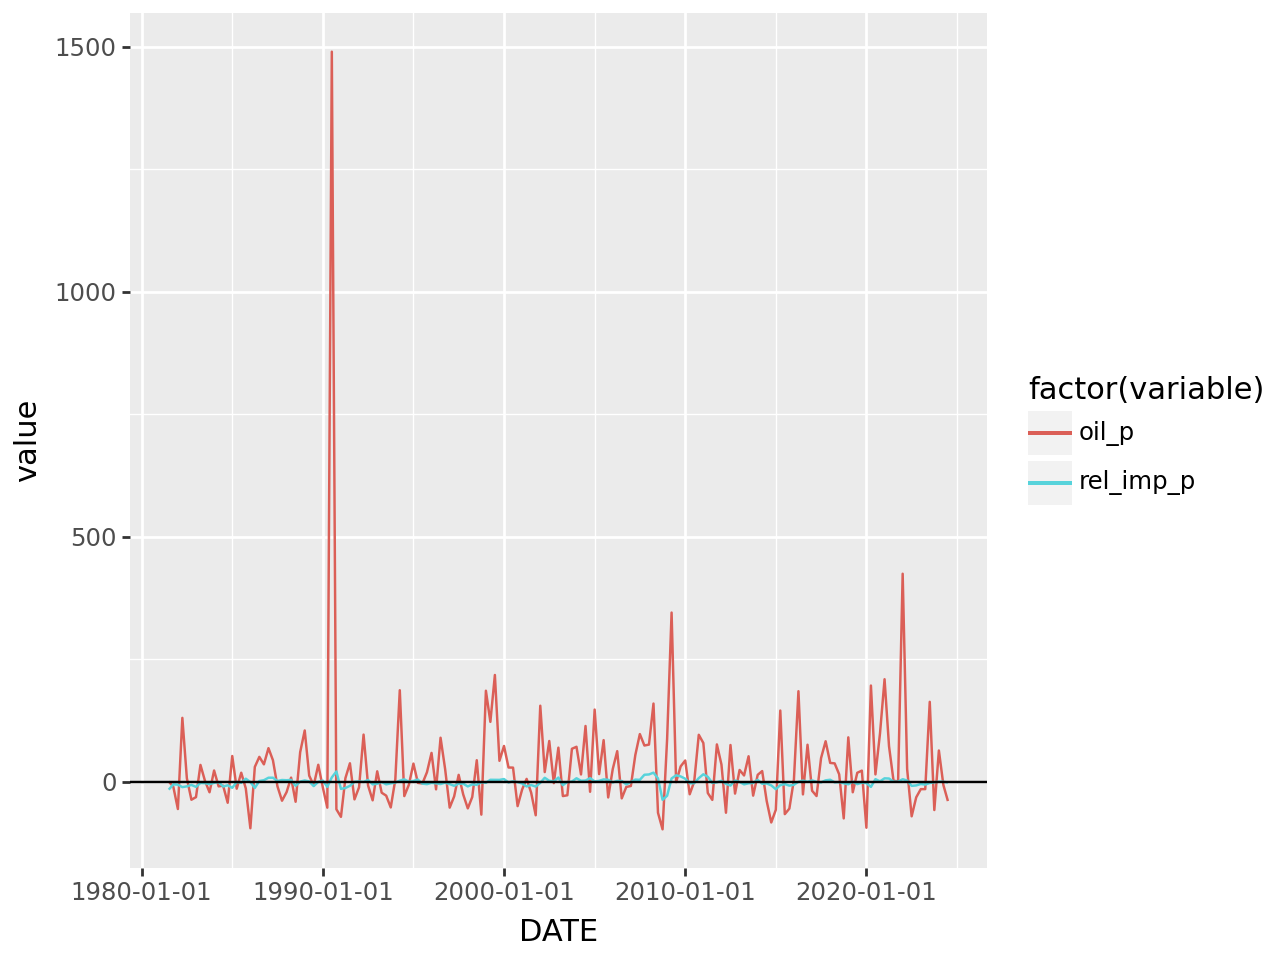

In [203]:
ip_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['rel_imp_p', 'oil_p']).dropna()

(
    p9.ggplot(ip_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

## Model

The state space model is specified in the original paper in appendix A.

In [204]:
from pymc.model import modelcontext

from pymc_extras.statespace.utils.constants import (
    ALL_STATE_DIM,
    ALL_STATE_AUX_DIM,
    OBS_STATE_DIM,
    SHOCK_DIM,
    TIME_DIM,
)
from pymc_extras.statespace.core.statespace import PyMCStateSpace
from pymc_extras.statespace.models.utilities import make_default_coords

class VlekkeKoopmanMellens2021(PyMCStateSpace):
    def __init__(self):
        k_states = 5 # size of the state vector x
        k_posdef = 5 # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        exog_data = self.make_and_register_data("exog_data", shape=(None, self.k_states))
        x0 = self.make_and_register_variable('x0', shape=(self.k_states,))
        P0 = self.make_and_register_variable('P0', shape=(self.k_states, self.k_states))
        sigma_sq_eps = self.make_and_register_variable('sigma_sq_eps', shape=())
        sigma_sq_eta = self.make_and_register_variable('sigma_sq_eta', shape=(self.k_posdef,))

        self.ssm['transition', :, :] = np.eye(self.k_states)
        assert self.k_states == self.k_posdef
        self.ssm['selection', :, :] = np.eye(self.k_states, self.k_posdef)

        self.ssm['initial_state', :] = x0
        self.ssm['initial_state_cov', :, :] = P0
        self.ssm["design"] = pt.expand_dims(exog_data, 1)  
        self.ssm['obs_cov', *np.diag_indices(self.k_endog)] = sigma_sq_eps
        self.ssm['state_cov', *np.diag_indices(self.k_posdef)] = sigma_sq_eta

    @property
    def param_names(self):
        return ['x0', 'P0', 'sigma_sq_eps', 'sigma_sq_eta']

    @property
    def state_names(self):
        return ['beta', 'theta', 'phi', 'gamma_1', 'gamma_2']

    @property
    def shock_names(self):
        return [f'{state}_shock' for state in self.state_names]

    @property
    def observed_states(self):
        return ['pi']

    @property
    def param_dims(self):
        return {
            'x0': (ALL_STATE_DIM,),
            'P0': (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
            'sigma_sq_eps': (OBS_STATE_DIM,),
            'sigma_sq_eta': (SHOCK_DIM,),
        }

    @property
    def coords(self):
        coords = make_default_coords(self)
        coords.update({'exog_data_dim': ['u_gap', 'pi_p', 'pi_h', 'rel_i_p', 'oil_p']})

        return coords

    @property
    def param_info(self):
        info = {
            'x0': {
                'shape': (self.k_states,),
                'constraints': 'None',
            },
            'P0': {
                'shape': (self.k_states, self.k_states),
                'constraints': 'Positive Semi-definite',
            },
            'sigma_sq_eps': {
                'shape': (self.k_endog,),
                'constraints': 'Positive',
            },
            'sigma_sq_eta': {
                'shape': (self.k_posdef,),
                'constraints': 'Positive',
            },
        }

        for name in self.param_names:
            info[name]['dims'] = self.param_dims[name]

        return info

    @property
    def data_names(self):
        return ['exog_data']
    
    @property
    def data_info(self):
        return {
            'exog_data': {
                'shape': (None, self.k_states),
                'dims': (TIME_DIM, 'exog_data_dim')
            }
        }

### Model Priors

Get priors for the initial state ($b_{40} = [\beta_t, \theta_t, \theta_t, \gamma_t, \gamma_t]$, $P_{40}$) as described in section 2.2 of the reference paper. We estimate equation (7) with maximum likelihood:
$$\pi_t = \beta_t (u_t - u_t^*) + \theta_t \pi_t^{e,P} + (1-\theta_t) \pi_t^{e,B} + \gamma_t \pi_t^M + \varepsilon_t \tag{7}$$
$$\pi_t^{e,B} = \frac{1}{4} \sum_{i=1}^4 \pi_{t-i}$$
$$\implies \pi_t - \pi_t^{e,B} = \beta_t (u_t - u_t^*) + \theta_t (\pi_t^{e,P} - \pi_t^{e,B}) + \gamma_t \pi_t^M + \varepsilon_t$$

In [225]:
import statsmodels.api as sm

# Take first 40 observations
prior_df = model_df.head(40)

y = prior_df[['cpi_meb']]
X = sm.add_constant(prior_df[['u_gap', 'e_p_cpi_1_meb', 'rel_imp_p']])

results = sm.OLS(y, X).fit()
print(results.summary())

# Map the found priors to the model parameters
idx_map = [1, 2, 2, 3, 3]
b_40 = np.take(results.params.values, idx_map)
P_40 = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        P_40[i,j] = results.cov_params().values[idx_map[i], idx_map[j]]

print('b_40:', b_40)
print('P_40:', P_40)

                            OLS Regression Results                            
Dep. Variable:                cpi_meb   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     6.428
Date:                Fri, 10 Jan 2025   Prob (F-statistic):            0.00134
Time:                        23:21:09   Log-Likelihood:                -87.016
No. Observations:                  40   AIC:                             182.0
Df Residuals:                      36   BIC:                             188.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1889      0.454      0.416

In [226]:
# TODO prior predictive checks?

### Model Fit Using Similar Priors to the Reference Paper

In [238]:
exog_data_df = model_df[['u_gap', 'e_p_cpi_1_meb', 'e_h_cpi_1_meb', 'rel_imp_p', 'oil_p']]
obs_df = model_df[['cpi_meb']]

vkm = VlekkeKoopmanMellens2021()

#b_40 = np.zeros(5, dtype="float")
#P_40 = np.eye(5) * 0.5
h0_mu, h0_sigma = 0.0, 0.5

with pm.Model(coords=vkm.coords) as mod:
    x0 = pm.Deterministic('x0', pt.as_tensor(b_40), dims=[ALL_STATE_DIM])
    P0 = pm.Deterministic('P0', pt.as_tensor(P_40), dims=[ALL_STATE_DIM, ALL_STATE_AUX_DIM])

    # For sigma_sq_nu and sigma_sq_eta priors, see table 2 in appendix C in the refrence paper
    #sigma_sq_nu = pm.InverseGamma('sigma_sq_nu', alpha=(vkm.k_states + 2) / 2, beta=0.454 / 2)
    sigma_sq_eta = pm.InverseGamma('sigma_sq_eta', alpha=(vkm.k_states + 2) / 2, beta=0.268 / 2, dims=[SHOCK_DIM])

    h = pm.Normal('h', mu=h0_mu, sigma=h0_sigma)
    sigma_sq_eps = pm.Deterministic('sigma_sq_eps', pt.exp(h))
    
    exog_data = pm.Data("exog_data", exog_data_df, dims=['time', 'exog_data_dim'])

    vkm.build_statespace_graph(data=obs_df, mode="JAX")
    idata = pm.sample(nuts_sampler="numpyro", chains=8, draws=1000)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (5,), constraints: None, dims: ('state',)
	P0 -- shape: (5, 5), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	sigma_sq_eps -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_sq_eta -- shape: (5,), constraints: Positive, dims: ('shock',)
The following Data variables should be assigned to the model inside a PyMC model block: 
	exog_data -- shape: (None, 5), dims: ('time', 'exog_data_dim')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

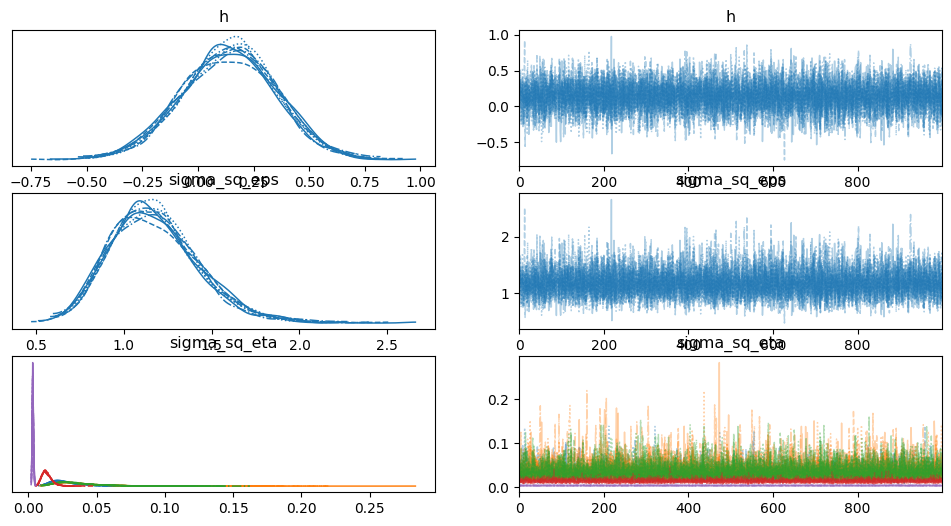

In [239]:
az.plot_trace(idata, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

In [240]:
cond_post = vkm.sample_conditional_posterior(idata)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F3B1A3EC820>), RNG(<Generator(PCG64) at 0x7F3B1A3EF840>), RNG(<Generator(PCG64) at 0x7F3B1A3ED8C0>), RNG(<Generator(PCG64) at 0x7F3B1A3ECF20>), RNG(<Generator(PCG64) at 0x7F3B1A3ECE40>), RNG(<Generator(PCG64) at 0x7F3D1098B920>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

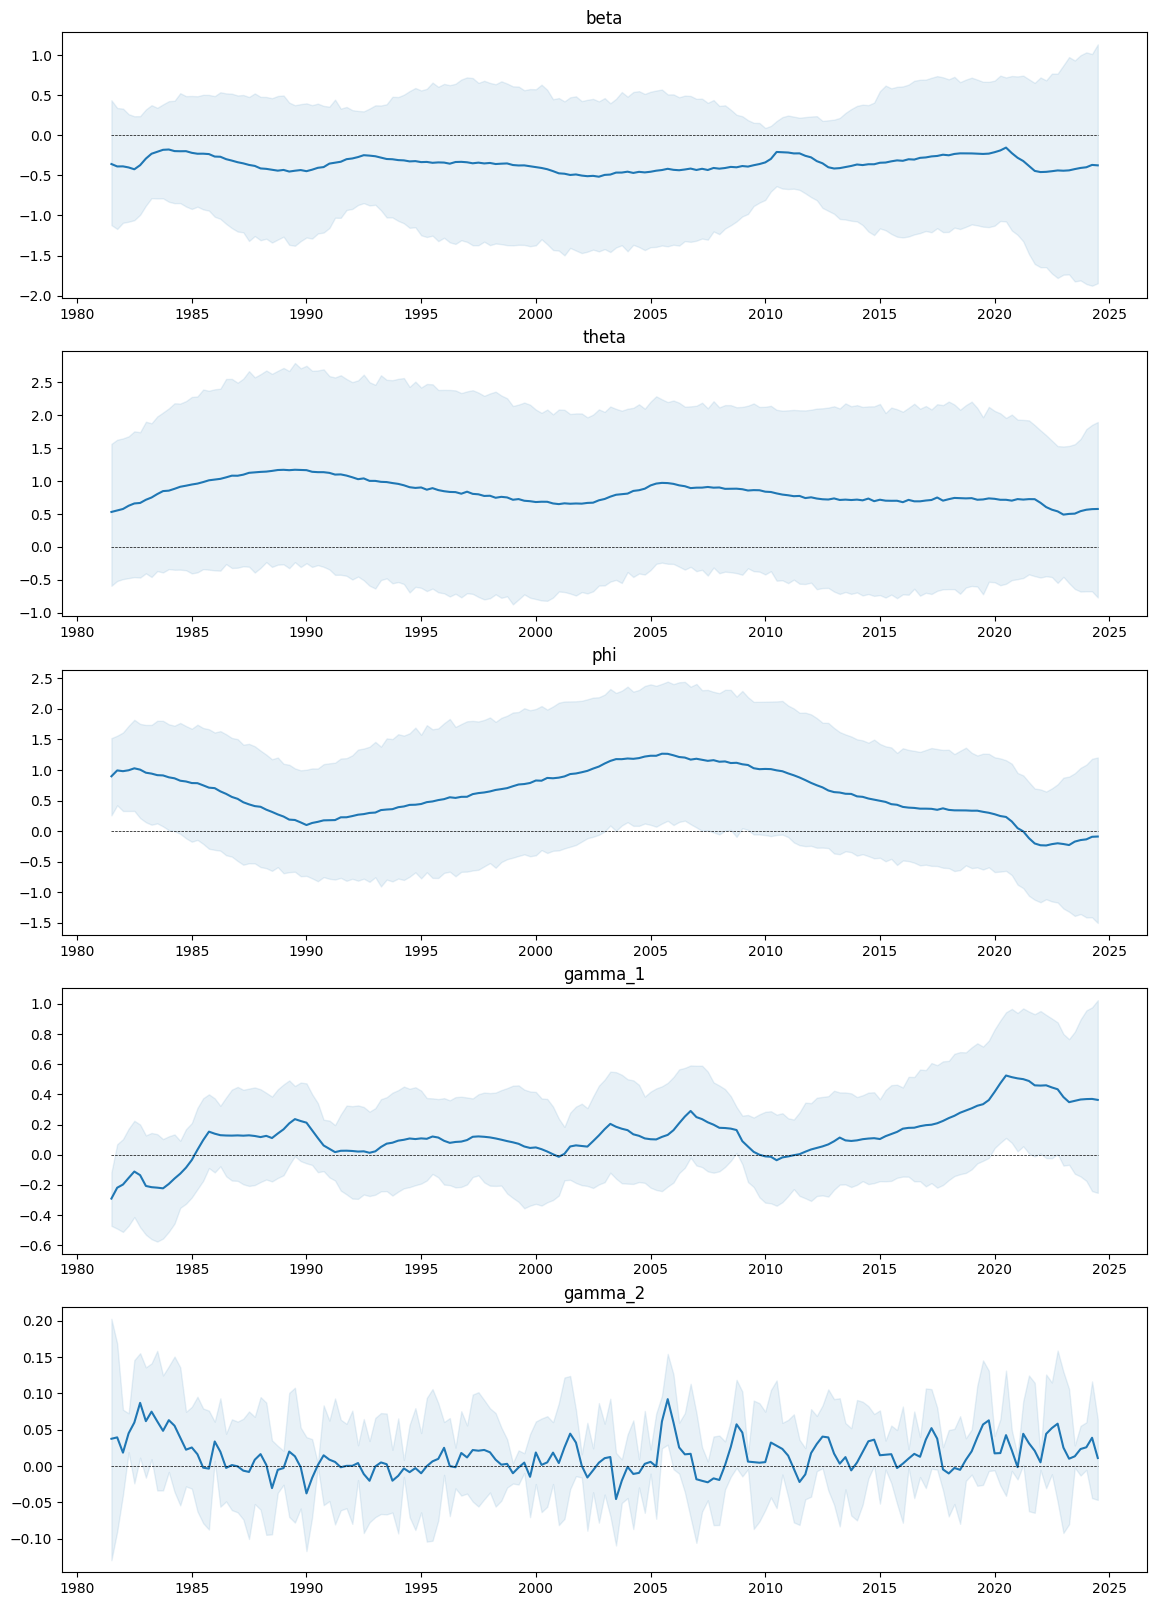

In [248]:
fig, ax = plt.subplots(5, 1, figsize=(14, 4*5))

x_values = cond_post.coords['time']

for axis, name in zip(fig.axes, ['beta', 'theta', 'phi', 'gamma_1', 'gamma_2']):
    data = cond_post.smoothed_posterior.sel(state=name)
    hdi = az.hdi(data).smoothed_posterior
    mean = data.median(dim=['chain', 'draw'])

    axis.plot(x_values, mean)
    axis.fill_between(x_values, *hdi.values.T, color='tab:blue', alpha=0.1)
    axis.hlines(y=0., xmin=x_values.min(), xmax=x_values.max(), linestyle='--', linewidth=0.5, color='black')
    axis.set_title(name)
    
plt.show()

In [237]:
#az.plot_pair(idata, var_names=['sigma_sq_eps', 'sigma_sq_eta'], divergences=True)
#plt.show()

### Model Fit Using Weakly Informative Priors

In [242]:
exog_data_df = model_df[['u_gap', 'e_p_cpi_1_meb', 'e_h_cpi_1_meb', 'rel_imp_p', 'oil_p']]
obs_df = model_df[['cpi_meb']]

vkm2 = VlekkeKoopmanMellens2021()

b_40 = np.zeros(5, dtype="float")
P_40 = np.eye(5) * 0.5
h0_mu, h0_sigma = 0.0, 0.5

with pm.Model(coords=vkm2.coords) as mod:
    x0 = pm.Deterministic('x0', pt.as_tensor(b_40), dims=[ALL_STATE_DIM])
    P0 = pm.Deterministic('P0', pt.as_tensor(P_40), dims=[ALL_STATE_DIM, ALL_STATE_AUX_DIM])

    # For sigma_sq_nu and sigma_sq_eta priors, see table 2 in appendix C in the refrence paper
    #sigma_sq_nu = pm.InverseGamma('sigma_sq_nu', alpha=(vkm2.k_states + 2) / 2, beta=0.454 / 2)
    #sigma_sq_eta = pm.InverseGamma('sigma_sq_eta', alpha=(vkm2.k_states + 2) / 2, beta=0.268 / 2, dims=[SHOCK_DIM])
    sigma_sq_eta = pm.Exponential('sigma_sq_eta', 0.2, dims=[SHOCK_DIM])

    #h = pm.Normal('h', mu=h0_mu, sigma=h0_sigma)
    #sigma_sq_eps = pm.Deterministic('sigma_sq_eps', pt.exp(h))
    sigma_sq_eps = pm.Exponential('sigma_sq_eps', 0.2)
    
    exog_data = pm.Data("exog_data", exog_data_df, dims=['time', 'exog_data_dim'])

    vkm2.build_statespace_graph(data=obs_df, mode="JAX")
    idata2 = pm.sample(nuts_sampler="numpyro", chains=8, draws=1000)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (5,), constraints: None, dims: ('state',)
	P0 -- shape: (5, 5), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	sigma_sq_eps -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_sq_eta -- shape: (5,), constraints: Positive, dims: ('shock',)
The following Data variables should be assigned to the model inside a PyMC model block: 
	exog_data -- shape: (None, 5), dims: ('time', 'exog_data_dim')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

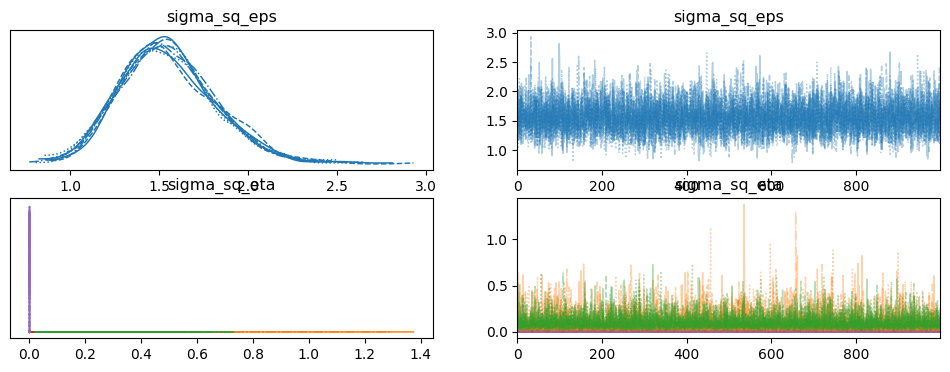

In [244]:
az.plot_trace(idata2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

In [245]:
cond_post2 = vkm.sample_conditional_posterior(idata2)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F3B32ECF4C0>), RNG(<Generator(PCG64) at 0x7F3B32ECF3E0>), RNG(<Generator(PCG64) at 0x7F3B32ECF300>), RNG(<Generator(PCG64) at 0x7F3B32ECF220>), RNG(<Generator(PCG64) at 0x7F3B32ECEDC0>), RNG(<Generator(PCG64) at 0x7F3B38DA8C80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

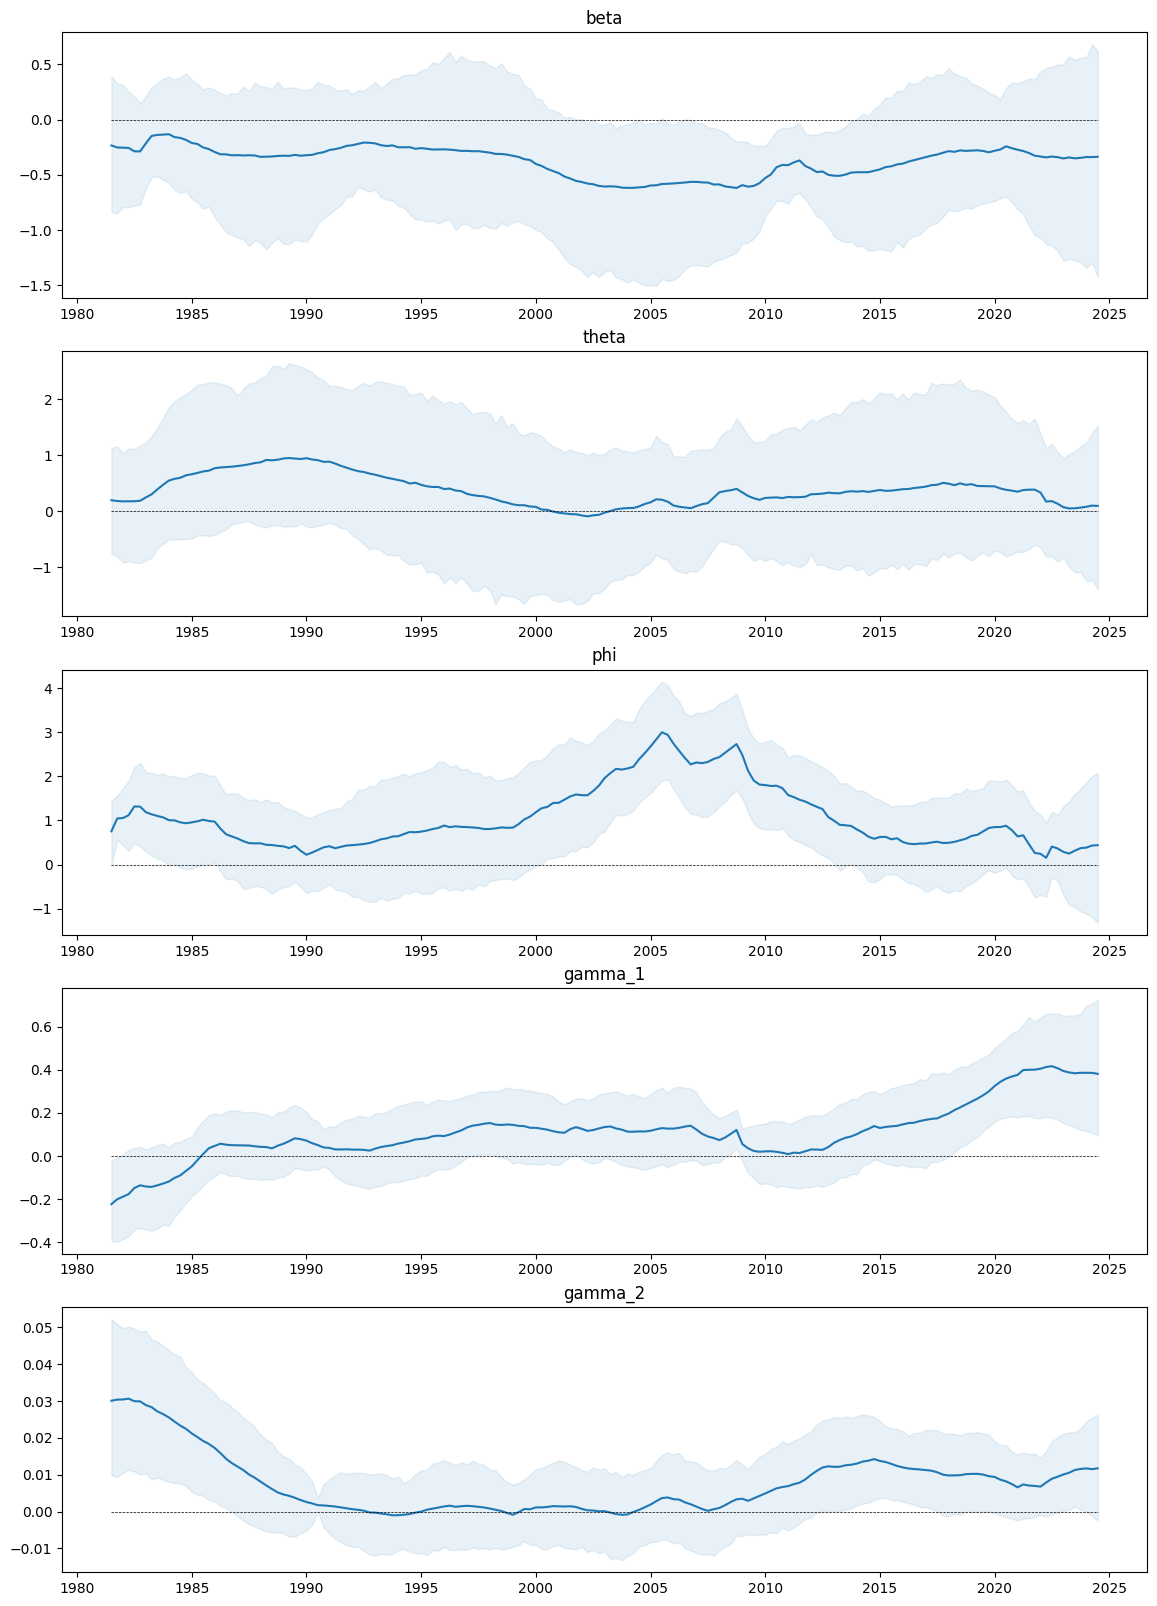

In [247]:
fig, ax = plt.subplots(5, 1, figsize=(14, 4*5))

x_values = cond_post2.coords['time']

for axis, name in zip(fig.axes, ['beta', 'theta', 'phi', 'gamma_1', 'gamma_2']):
    data = cond_post2.smoothed_posterior.sel(state=name)
    hdi = az.hdi(data).smoothed_posterior
    mean = data.median(dim=['chain', 'draw'])

    axis.plot(x_values, mean)
    axis.fill_between(x_values, *hdi.values.T, color='tab:blue', alpha=0.1)
    axis.hlines(y=0., xmin=x_values.min(), xmax=x_values.max(), linestyle='--', linewidth=0.5, color='black')
    axis.set_title(name)
    
plt.show()